### Install necessary packages (Run only if not installed)

In [ ]:
%pip install pandas matplotlib seaborn nltk scikit-learn 

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


### Import required libraries

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import sent_tokenize, word_tokenize
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
import time
import pickle
import os


# Ensure necessary NLTK data is downloaded
nltk.download('wordnet')
    

[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

### Function to perform data manipulation

In [2]:

def perform_data_manipulation():
    df = pd.read_csv("data1.csv")
    for index in df.index:
        if df.loc[index, "label"] == -1:
            df.loc[index, "label"] = 1
    return df
    

### Function to display data distribution

In [3]:

def perform_data_distribution(df):
    total = df.shape[0]
    num_non_toxic = df[df['label'] == 0].shape[0]
    
    slices = [num_non_toxic / total, (total - num_non_toxic) / total]
    labeling = ['Non-Toxic', 'Toxic']
    explode = [0.2, 0]
    
    plt.pie(slices, explode=explode, shadow=True, autopct="%1.1f%%", labels=labeling, wedgeprops={'edgecolor': 'black'})
    plt.title('Number of Toxic Vs Non-Toxic Test Sample')
    plt.tight_layout()
    plt.show()
    

### Function to clean the dataset

In [4]:

def remove_pattern(input_txt, pattern):
    if isinstance(input_txt, str):
        r = re.findall(pattern, input_txt)
        for i in r:
            input_txt = re.sub(i, '', input_txt)
        return input_txt
    else:
        return ""

def dataset_cleaning(df):
    df['length_content'] = df['headline'].str.len()
    combined_df = pd.concat([df, df], ignore_index=True)
    combined_df['tidy_tweet'] = np.vectorize(remove_pattern)(combined_df['headline'], r"@[\w]*")
    combined_df['tidy_tweet'] = combined_df['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")
    combined_df['tidy_tweet'] = combined_df['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 3]))
    combined_df['length_tidy_tweet'] = combined_df['tidy_tweet'].str.len()

    tokenized_tweet = combined_df['tidy_tweet'].apply(lambda x: x.split())
    lemmatizer = nltk.stem.WordNetLemmatizer()
    tokenized_tweet = tokenized_tweet.apply(lambda x: [lemmatizer.lemmatize(i) for i in x])
    for i in range(len(tokenized_tweet)):
        tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
    combined_df['tidy_tweet'] = tokenized_tweet

    return combined_df, df
    

### Function to split dataset and apply TF-IDF vectorization

In [5]:

def perform_data_split(x, y, combined_df, df):
    X_train, X_test, y_train, y_test = train_test_split(combined_df['tidy_tweet'], combined_df['label'], test_size=x, random_state=y)
    print(f"Number of rows in the total dataset: {combined_df.shape[0]}")
    print(f"Number of rows in the train dataset: {X_train.shape[0]}")
    print(f"Number of rows in the test dataset: {X_test.shape[0]}")

    with open("stopwords.txt", "r") as file:
        content_list = file.read().split("\n")

    tfidfvector = TfidfVectorizer(stop_words=content_list, lowercase=True)
    training_data = tfidfvector.fit_transform(X_train.values.astype('U'))
    testing_data = tfidfvector.transform(X_test.values.astype('U'))

    filename = 'tfidfvectorizer11.pkl'
    pickle.dump(tfidfvector.vocabulary_, open(filename, 'wb'))

    return X_train, X_test, y_train, y_test, testing_data, filename, training_data, content_list
    

### Function to train and evaluate models

In [6]:
def train_and_evaluate_models(X_train, y_train, X_test, y_test):
    models = {
        'LinearSVC': LinearSVC(),
        'SGDClassifier': SGDClassifier()
    }

    performance_metrics = {
        'Model': [],
        'Train Accuracy': [],
        'Train F1 Score': [],
        'Train Precision': [],
        'Train Recall': [],
        'Test Accuracy': [],
        'Test F1 Score': [],
        'Test Precision': [],
        'Test Recall': [],
        'Prediction Time (s)': []
    }

    for model_name, model in models.items():
        start_time = time.time()
        model.fit(X_train, y_train)
        predictions_train = model.predict(X_train)
        predictions_test = model.predict(X_test)
        end_time = time.time()
        prediction_time = end_time - start_time
        
        performance_metrics['Model'].append(model_name)
        performance_metrics['Train Accuracy'].append(accuracy_score(y_train, predictions_train))
        performance_metrics['Train F1 Score'].append(f1_score(y_train, predictions_train, average='weighted'))
        performance_metrics['Train Precision'].append(precision_score(y_train, predictions_train, average='weighted'))
        performance_metrics['Train Recall'].append(recall_score(y_train, predictions_train, average='weighted'))
        performance_metrics['Test Accuracy'].append(accuracy_score(y_test, predictions_test))
        performance_metrics['Test F1 Score'].append(f1_score(y_test, predictions_test, average='weighted'))
        performance_metrics['Test Precision'].append(precision_score(y_test, predictions_test, average='weighted'))
        performance_metrics['Test Recall'].append(recall_score(y_test, predictions_test, average='weighted'))
        performance_metrics['Prediction Time (s)'].append(prediction_time)
        
        model_save_folder = "models"
        model_filename = os.path.join(model_save_folder, f"{model_name}_model.pkl")
        with open(model_filename, 'wb') as file:
            pickle.dump(model, file)

    return performance_metrics

### Function to plot performance metrics

In [7]:
def plot_performance_metrics(performance_metrics):
    df_metrics = pd.DataFrame(performance_metrics)
    df_metrics.set_index('Model', inplace=True)

    fig, ax = plt.subplots(2, 1, figsize=(12, 12))

    # Plot Training and Testing metrics
    df_metrics[[ 'Train F1 Score', 'Train Precision', 'Train Recall',
                 'Test F1 Score', 'Test Precision', 'Test Recall']].plot(
        kind='bar', ax=ax[0])
    ax[0].set_title('Model Performance Metrics')
    ax[0].set_ylabel('Score')
    ax[0].set_ylim(0, 1)
    ax[0].legend(loc='lower right')
    
    df_metrics[['Train Accuracy', 'Test Accuracy']].plot(kind='bar', figsize=(8, 5))
    plt.title('Model Accuracy Comparison')
    plt.ylabel('Accuracy')

    # Plot Prediction Time
    df_metrics[['Prediction Time (s)']].plot(kind='bar', ax=ax[1], color='orange')
    ax[1].set_title('Model Prediction Time')
    ax[1].set_ylabel('Time (s)')

    plt.tight_layout()
    plt.show()


### Run the processing pipeline

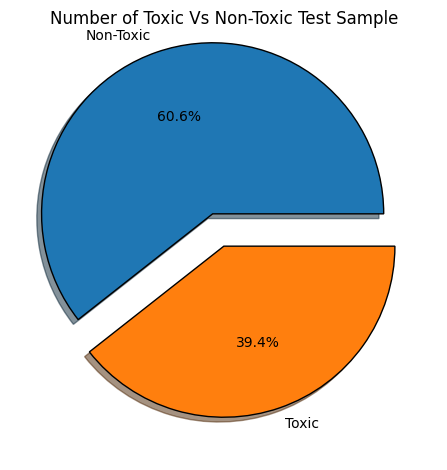

Number of rows in the total dataset: 26918
Number of rows in the train dataset: 21534
Number of rows in the test dataset: 5384


C:\Users\navaneeth\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ain', 'aren', 'couldn', 'daren', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'll', 'mayn', 'mightn', 'mon', 'mustn', 'needn', 'oughtn', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(



LinearSVC Performance:
----------------------------------------
Training Metrics:
  Accuracy  = 0.9568
  F1 Score  = 0.9569
  Precision = 0.9572
  Recall    = 0.9568

Testing Metrics:
  Accuracy  = 0.9045
  F1 Score  = 0.9049
  Precision = 0.9063
  Recall    = 0.9045

Prediction Time = 0.2511 seconds
----------------------------------------

SGDClassifier Performance:
----------------------------------------
Training Metrics:
  Accuracy  = 0.8924
  F1 Score  = 0.8920
  Precision = 0.8920
  Recall    = 0.8924

Testing Metrics:
  Accuracy  = 0.8215
  F1 Score  = 0.8203
  Precision = 0.8204
  Recall    = 0.8215

Prediction Time = 0.0748 seconds
----------------------------------------


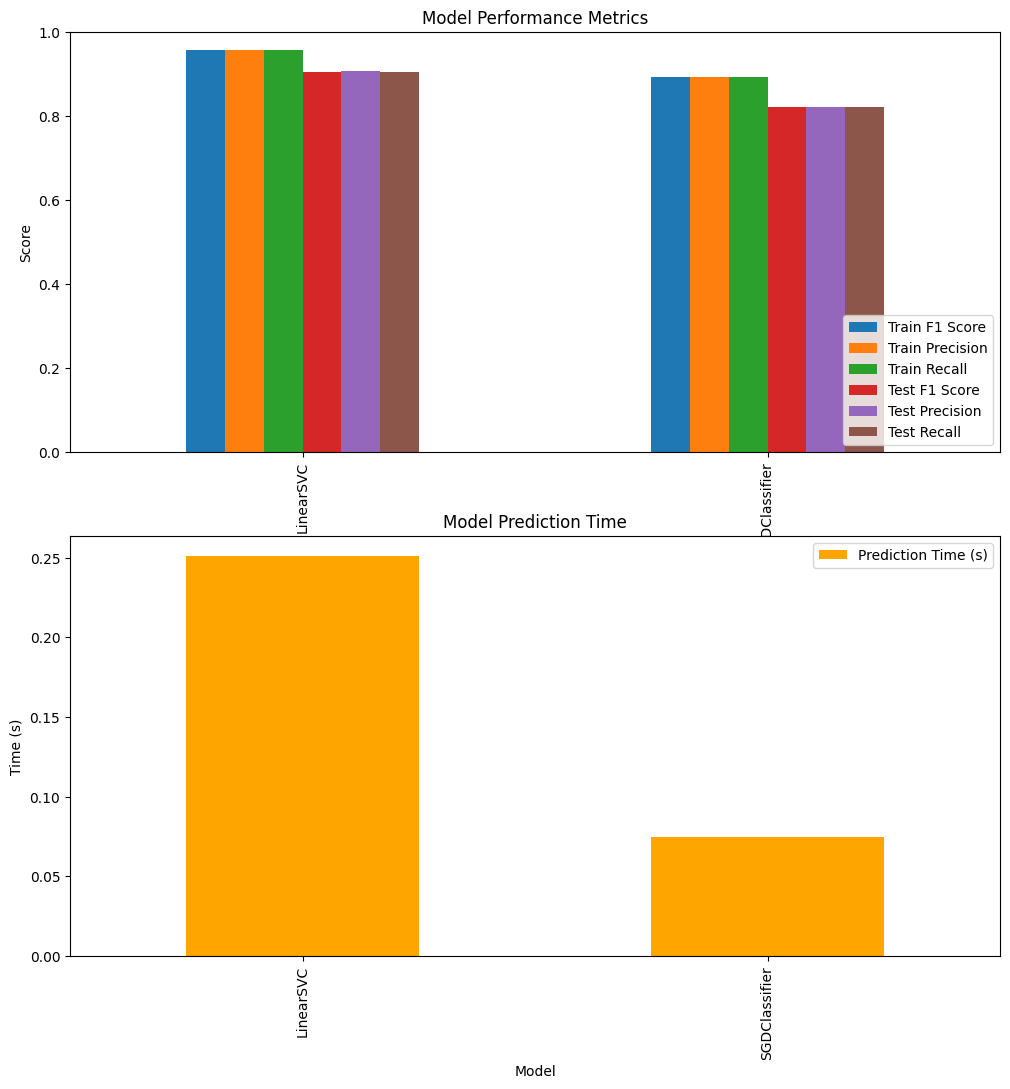

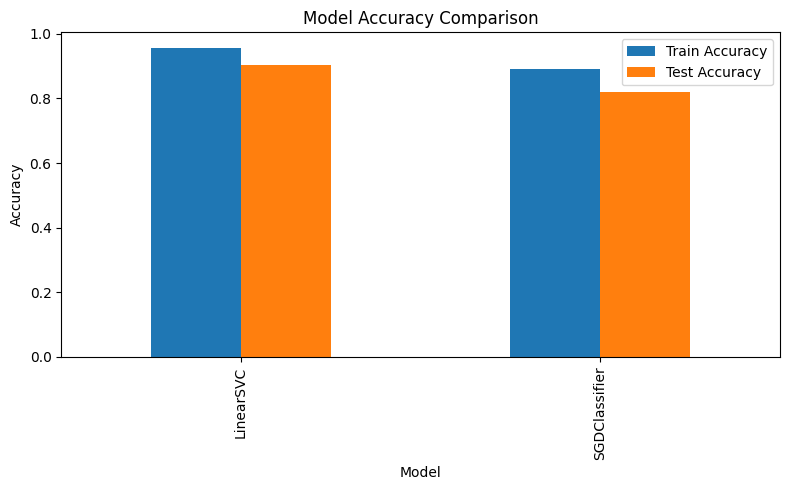

In [9]:

df = perform_data_manipulation()
perform_data_distribution(df)
combined_df, df = dataset_cleaning(df)
X_train, X_test, y_train, y_test, testing_data, filename, training_data, content_list = perform_data_split(0.2, 42, combined_df, df)
performance_metrics = train_and_evaluate_models(training_data, y_train, testing_data, y_test)
# Print all metrics for each model from the existing performance_metrics dictionary
for i, model_name in enumerate(performance_metrics['Model']):
    print(f"\n{model_name} Performance:")
    print("-" * 40)
    print("Training Metrics:")
    print(f"  Accuracy  = {performance_metrics['Train Accuracy'][i]:.4f}")
    print(f"  F1 Score  = {performance_metrics['Train F1 Score'][i]:.4f}")
    print(f"  Precision = {performance_metrics['Train Precision'][i]:.4f}")
    print(f"  Recall    = {performance_metrics['Train Recall'][i]:.4f}")
    
    print("\nTesting Metrics:")
    print(f"  Accuracy  = {performance_metrics['Test Accuracy'][i]:.4f}")
    print(f"  F1 Score  = {performance_metrics['Test F1 Score'][i]:.4f}")
    print(f"  Precision = {performance_metrics['Test Precision'][i]:.4f}")
    print(f"  Recall    = {performance_metrics['Test Recall'][i]:.4f}")
    
    print(f"\nPrediction Time = {performance_metrics['Prediction Time (s)'][i]:.4f} seconds")
    print("-" * 40)


plot_performance_metrics(performance_metrics)
    

### Best Model based of Prediction Time


In [ ]:

best_model = min(performance_metrics['Model'], key=lambda model: performance_metrics['Prediction Time (s)'][performance_metrics['Model'].index(model)])
print(f"The best model based on Prediction Time is: {best_model}")


The best model based on Prediction Time is: SGDClassifier


### Testing the Model

In [ ]:
data = ["test"]

tfidf_vector = TfidfVectorizer(stop_words=content_list, lowercase=True, vocabulary=pickle.load(open("tfidfvectorizer11.pkl", "rb")))
preprocessed_data = tfidf_vector.fit_transform(data)

trained_model = pickle.load(open('models/SGDClassifier_model.pkl', 'rb'))
print(trained_model.predict(preprocessed_data))

if(trained_model.predict(preprocessed_data)==1):
    print("bulling")
else:
    print("non-bulling")

[0]
non-bulling


C:\Users\navaneeth\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ain', 'aren', 'couldn', 'daren', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'll', 'mayn', 'mightn', 'mon', 'mustn', 'needn', 'oughtn', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(
